In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)

for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

import sys
sys.version


C:\Users\Chanv\anaconda3\envs\tf2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Num GPUs Available:  1
True
2.10.1


'3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC v.1929 64 bit (AMD64)]'

In [2]:
DATASET_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train'
BATCH_SIZE = 16
EPOCHS = 3
TEACHER1_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped2weights/lstm_model2.hdf5"
TEACHER2_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/simpleAutoencoder2.hdf5"
STUDENT1_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_model1.hdf5"
STUDENT2_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd1.hdf5"
STUDENT3_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd2.h5"
STUDENT4_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd3.h5"
STUDENT5_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd4.h5"
STUDENT6_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd5.h5"
STUDENT7_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd6.h5"
STUDENT8_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd7.h5"
STUDENT9_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped1weights/student_modelkd8.h5"


test_path1 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test007'
test_path2 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test002'
test_path3 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test004'
test_path4 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test003'
test_path5 = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test008'


MEAN_MSE_VALUES_OBJECT_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/mean_mse_ped2.pkl"
# MAX_MSE_VALUES_OBJECT_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/max_mse_ped2.pkl"

MODEL_METRICS_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/model_metrics.pkl"
MODEL_METRICS_TABULATED_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/model_metrics_tabulated_ped2.csv"

# student1 = no kd
# student2 = kd with teacher 1, student alpha as 0.5, with teacher1 alpha as 0.5
# student3 = kd with teacher 1 and 2, student alpha as 0.5, with teacher1 alpha as 0.5, teacher2 alpha as 0.2
# student4 = kd with teacher 1 and 2, student alpha as 0.4, with teacher1 alpha as 0.4, teacher2 alpha as 0.2
# student5 = kd with teacher 1 and 2, student alpha as 1, with teacher1 alpha as 0.7, teacher2 alpha as 0.3
# student6 = kd with teacher 1 and 2, student alpha as 0.4, with teacher1 alpha as 0.5, teacher2 alpha as 0.1
# student7 = kd with teacher 1 and 2, student alpha as 0.5, with teacher1 alpha as 0.5, teacher2 alpha as 0, avg of both teacher
# student8 = kd with dynamic weight allocation to both teacher distillation loss and student reconstruction loss
# student9 = kd with teacher 2, student alpha as 0.5, with teacher2 alpha as 0.5

In [3]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import shelve
import matplotlib.pyplot as plt

In [4]:
def plot_regularity(sequences, reconstructed_sequences):
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,len(sequences))])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost) - np.min(sequences_reconstruction_cost))
    sr = 1.0 - sa
    # ( mse - min_mse ) / max_mse - min_mse
    # plot the regularity scores
    sequence_numbers = [i for i in range(1, len(sequences) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    plt.plot(sequence_numbers, sr)
    plt.ylabel('Regularity score')
    plt.xlabel('Sequence Number')
    plt.show()

    return sr

In [5]:
def get_mse(sequences, reconstructed_sequences):
    mse = np.mean(np.square(sequences - reconstructed_sequences), axis=(1,2,3))
    return mse

In [6]:
def plot_mse_change(mse_values, mean_mse=0, legend = None, doPlotThreshold = False):


    # Plot MSE against frame number
    sequence_numbers = [i for i in range(1, len(mse_values) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    
    plt.plot(sequence_numbers, mse_values, color='g', marker='o', linestyle='-')
    plt.xlabel('Sequence Number')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Against Sequence Number')
    plt.grid(True)

    if doPlotThreshold:
        plt.axhline(y=mean_mse, color='c', linestyle='--', label='Mean MSE')
        plt.legend(legend)
    plt.show()

In [7]:
import cv2
import os
import numpy as np

def preprocess_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []


    # Loop through each video sequence in the dataset
    for sequence_folder in os.listdir(data_path):
        sequence_path = os.path.join(data_path, sequence_folder)
        if sequence_path.endswith("Store"):
            continue
        print(sequence_path)

        frames = []
        # Read frames from the video sequence
        for frame_file in sorted(os.listdir(sequence_path)):
            if frame_file.endswith("Store"):
                continue

            if len(frames) == 10:
                preprocessed_data.append(frames)
                frames = []

            frame_path = os.path.join(sequence_path, frame_file)
            frame = cv2.imread(frame_path)
            frame = cv2.resize(frame, output_shape)  # Resize frame
            # frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # frame_gray = frame_gray[:, :, np.newaxis]
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
            # frame_ray = frame_gray.astype(np.float32) / 255.0
            frames.append(frame)
        preprocessed_data.append(frames)

    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)

    return preprocessed_data


# Path to the Ped2 dataset
data_path = DATASET_PATH

# Preprocess the Ped2 dataset
preprocessed_data = preprocess_dataset(data_path)
preprocessed_data = preprocessed_data[:150]

# Check the shape of the preprocessed data
print("Preprocessed dataset shape:", preprocessed_data.shape)


C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train001
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train002
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train003
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train004
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train005
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train006
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train007
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train008
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train009
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train010
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train011
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train012
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train013
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train014
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train015
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train016
Preprocessed dataset shape: (150, 10, 12

In [8]:
from sklearn.model_selection import train_test_split

# Build autoencoder model
train_data, val_data = train_test_split(preprocessed_data, test_size=0.2, random_state=42)

# Teacher models

## Teacher 1

In [9]:
from keras.models import load_model
teacher1 = load_model(TEACHER1_PATH)
teacher1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 32, 32, 64)   23296     
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 32, 32, 64)   128       
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 16, 16, 32)   51232     
 tributed)                                                       
                                                                 
 layer_normalization_1 (Laye  (None, 10, 16, 16, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 16, 16, 64)    2

## Teacher 2

In [10]:
from keras.models import load_model
teacher2 = load_model(TEACHER2_PATH)
teacher2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 128, 128, 128  10496     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 64, 64, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 64, 64, 64)    221248    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 32, 32, 64)    110656    
                                                        

# Student

In [11]:
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D, LayerNormalization
from keras.models import Sequential, load_model

def get_student_model():
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(32, (5, 5), strides=2, padding="same"), batch_input_shape=(None, 10, 128, 128, 3)))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(32, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    return seq


### Without KD

In [12]:
# Create the student model
student_model1 = get_student_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 64, 64, 32)   2432      
 ibuted)                                                         
                                                                 
 layer_normalization (LayerN  (None, 10, 64, 64, 32)   64        
 ormalization)                                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_1 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                              

In [13]:
# Train autoencoder
student_model1.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6))
# student_model1.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=BATCH_SIZE)
# student_model1.save(STUDENT1_PATH)
student_model1 = load_model(STUDENT1_PATH)


### With KD

In [14]:
def compute_correlation(x, y):
    x_mean = tf.reduce_mean(x, axis=(1, 2, 3), keepdims=True)
    y_mean = tf.reduce_mean(y, axis=(1, 2, 3), keepdims=True)
    x_centered = x - x_mean
    y_centered = y - y_mean

    numerator = tf.reduce_sum(x_centered * y_centered, axis=(1, 2, 3))
    denominator = tf.sqrt(tf.reduce_sum(tf.square(x_centered), axis=(1, 2, 3))) * tf.sqrt(tf.reduce_sum(tf.square(y_centered), axis=(1, 2, 3)))
    correlation = numerator / (denominator + tf.keras.backend.epsilon())
    return correlation

In [15]:

class AutoencoderDistiller(keras.Model):
    def __init__(self, student, teacher1, teacher2=None):
        super(AutoencoderDistiller, self).__init__()
        self.teacher1 = teacher1
        self.teacher2 = teacher2
        self.student = student


    def compile(self, optimizer, metrics, reconstruction_loss_fn, distillation_loss_fn, alpha, sAlpha=0.5, beta=0, method='Normal'):
        super(AutoencoderDistiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.reconstruction_loss_fn = reconstruction_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.sAlpha = sAlpha
        self.alpha = alpha
        self.beta = beta
        self.method = method

    def train_step(self, data):
        x, _ = data  # Unpack input data (no labels)

        with tf.GradientTape() as tape:
            # Forward pass of student
            reconstructed_x = self.student(x, training=True)
            # Compute reconstruction loss
            reconstruction_loss = self.reconstruction_loss_fn(x, reconstructed_x)

            # Forward pass of teacher
            teacher1_reconstructed_x = self.teacher1(x, training=False)

            # Compute distillation loss
            distillation_loss1 = self.distillation_loss_fn(reconstructed_x, teacher1_reconstructed_x)



            loss = 0
            # Total loss
            if(self.method == 'Normal'):
                loss = self.sAlpha * reconstruction_loss + self.alpha * distillation_loss1

            if self.teacher2 is not None:
                 # Forward pass of teacher
                teacher2_reconstructed_x = self.teacher2(x, training=False)
                # Compute distillation loss
                distillation_loss2 = self.distillation_loss_fn(reconstructed_x, teacher2_reconstructed_x)



                if(self.method == 'Normal'):
                    loss += self.beta * distillation_loss2
                elif(self.method == 'Average'):
                    loss = self.sAlpha * reconstruction_loss + self.alpha * ((distillation_loss1 + distillation_loss2) / 2)
                elif(self.method == 'Dynamic'):
                   
                    reconstruction_correlation = (compute_correlation(tf.reduce_mean(x, axis=-1, keepdims=True), reconstructed_x) + 1) / 2
                    distillation1_correlation = (compute_correlation(reconstructed_x, teacher1_reconstructed_x) + 1) / 2
                    distillation2_correlation = (compute_correlation(reconstructed_x, tf.reduce_mean(teacher2_reconstructed_x, axis=-1, keepdims=True)) + 1) / 2

                   
                    total_weight = reconstruction_correlation + distillation1_correlation + distillation2_correlation
                    reconstruction_weight = reconstruction_correlation / total_weight
                    distillation1_weight = distillation1_correlation / total_weight
                    distillation2_weight = distillation2_correlation / total_weight

                    self.sAlpha = reconstruction_weight
                    self.alpha = distillation1_weight
                    self.beta = distillation2_weight

                    loss = self.sAlpha * reconstruction_loss + self.alpha * distillation_loss1 + self.beta * distillation_loss2

        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update the metrics
        self.compiled_metrics.update_state(x, reconstructed_x)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        if self.teacher2 is not None:
            results.update({"reconstruction_loss": reconstruction_loss, "distillation_loss_t1": distillation_loss1, "distillation_loss_t2": distillation_loss2}) #, 'r_weight': reconstruction_weight, 'd1_weight': distillation1_weight, 'd2_weight': distillation2_weight
        else:
            results.update({"reconstruction_loss": reconstruction_loss, "distillation_loss_t1": distillation_loss1})
        return results

    def test_step(self, data):
        x, _ = data  # Unpack input data (no labels)

        # Forward pass of student
        reconstructed_x = self.student(x, training=False)

        # Compute reconstruction loss
        reconstruction_loss = self.reconstruction_loss_fn(x, reconstructed_x)

        # Update the metrics
        self.compiled_metrics.update_state(x, reconstructed_x)

        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"reconstruction_loss": reconstruction_loss})
        return results

    def predict(self, data):
        # Perform forward pass inference using the student model
        return self.student(data, training=False)




### Single teacher 1

In [16]:
student_model_kd1 = get_student_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_3 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_4 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                            

In [17]:
from tensorflow.keras.optimizers import Adam

student_model_kd1 = AutoencoderDistiller(student=student_model_kd1, teacher1=teacher1, teacher2 = None)
student_model_kd1.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)


In [18]:
# # Train autoencoder
# student_model_kd1.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)
# student_model_kd1.student.save_weights(STUDENT2_PATH)

student_model_kd1.built = True
student_model_kd1.student.load_weights(STUDENT2_PATH)
student_model_kd1.summary()

Model: "autoencoder_distiller"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 128, 128, 3)   951171    
                                                                 
 sequential_1 (Sequential)   (None, 10, 128, 128, 1)   105985    
                                                                 
Total params: 1,057,156
Trainable params: 1,057,156
Non-trainable params: 0
_________________________________________________________________


### Single teacher 2

In [19]:
student_model_kd8 = get_student_model()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_6 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_7 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 128, 128, 32)  25632    
 tributed)                                            

In [20]:
from tensorflow.keras.optimizers import Adam

student_model_kd8 = AutoencoderDistiller(student=student_model_kd8, teacher1=teacher2, teacher2 = None)
student_model_kd8.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)


In [21]:
# Train autoencoder
# student_model_kd8.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)
# student_model_kd8.student.save_weights(STUDENT9_PATH)

student_model_kd8.built = True
student_model_kd8.student.load_weights(STUDENT9_PATH)
student_model_kd8.summary()

Model: "autoencoder_distiller_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 10, 128, 128, 3)   574083    
                                                                 
 sequential_2 (Sequential)   (None, 10, 128, 128, 1)   105985    
                                                                 
Total params: 680,068
Trainable params: 680,068
Non-trainable params: 0
_________________________________________________________________


### Two teachers 1

In [22]:
student_model_kd2 = get_student_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDis  (None, 10, 64, 64, 32)   2432      
 tributed)                                                       
                                                                 
 layer_normalization_9 (Laye  (None, 10, 64, 64, 32)   64        
 rNormalization)                                                 
                                                                 
 conv_lstm2d_3 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_10 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_10 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [23]:
from tensorflow.keras.optimizers import Adam

student_model_kd2 = AutoencoderDistiller(student=student_model_kd2, teacher1=teacher1, teacher2 = teacher2)
student_model_kd2.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0.2
)

In [24]:
# # # Train autoencoder
# student_model_kd2.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # # Save the model
# student_model_kd2.student.save_weights(STUDENT3_PATH)

In [25]:
student_model_kd2.built = True
student_model_kd2.student.load_weights(STUDENT3_PATH)

In [26]:
student_model_kd2.evaluate(val_data, val_data)

1/1 [==============================] - 6s 6s/step - mean_squared_error: 0.0037 - reconstruction_loss: 0.0037


[0.003719662083312869, 0.003719662083312869]

### Two teachers 2

In [27]:
student_model_kd3 = get_student_model()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_12 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_12 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_13 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_13 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [28]:
from tensorflow.keras.optimizers import Adam

student_model_kd3 = AutoencoderDistiller(student=student_model_kd3, teacher1=teacher1, teacher2 = teacher2)
student_model_kd3.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.4,
    sAlpha=0.4,
    beta=0.2
)

In [29]:
# # # Train autoencoder
# student_model_kd3.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # # Save the model
# student_model_kd3.student.save_weights(STUDENT4_PATH)

In [30]:
student_model_kd3.built = True
student_model_kd3.student.load_weights(STUDENT4_PATH)

In [31]:
student_model_kd3.evaluate(val_data, val_data)

1/1 [==============================] - 1s 1000ms/step - mean_squared_error: 0.0034 - reconstruction_loss: 0.0034


[0.003402644069865346, 0.003402644069865346]

### Two teachers 3

In [32]:
student_model_kd4 = get_student_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_15 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_15 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_16 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_16 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [33]:
from tensorflow.keras.optimizers import Adam

student_model_kd4 = AutoencoderDistiller(student=student_model_kd4, teacher1=teacher1, teacher2 = teacher2)
student_model_kd4.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.7,
    sAlpha=1,
    beta=0.3
)

In [34]:
# # # Train autoencoder
# student_model_kd4.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # # Save the model
# student_model_kd4.student.save_weights(STUDENT5_PATH)

In [35]:
student_model_kd4.built = True
student_model_kd4.student.load_weights(STUDENT5_PATH)

In [36]:
student_model_kd4.evaluate(val_data, val_data)

1/1 [==============================] - 1s 1s/step - mean_squared_error: 0.0036 - reconstruction_loss: 0.0036


[0.00355538516305387, 0.00355538516305387]

### Two teachers 4

In [37]:
student_model_kd5 = get_student_model()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_18 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_19 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_19 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [38]:
from tensorflow.keras.optimizers import Adam

student_model_kd5 = AutoencoderDistiller(student=student_model_kd5, teacher1=teacher1, teacher2 = teacher2)
student_model_kd5.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.4,
    beta=0.1
)

In [39]:
# # Train autoencoder
# student_model_kd5.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd5.student.save_weights(STUDENT6_PATH)

In [40]:
student_model_kd5.built = True
student_model_kd5.student.load_weights(STUDENT6_PATH)

In [41]:
student_model_kd5.evaluate(val_data, val_data)

1/1 [==============================] - 1s 1s/step - mean_squared_error: 0.0038 - reconstruction_loss: 0.0038


[0.0037532567512243986, 0.0037532567512243986]

### Two teachers 5  avg

In [42]:
student_model_kd6 = get_student_model()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_21 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_21 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_7 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_22 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_22 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [43]:
from tensorflow.keras.optimizers import Adam

student_model_kd6 = AutoencoderDistiller(student=student_model_kd6, teacher1=teacher1, teacher2 = teacher2)
student_model_kd6.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=0.5,
    sAlpha=0.5,
    beta=0,
    method='Average'
)

In [44]:
# # Train autoencoder
# student_model_kd6.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd6.student.save_weights(STUDENT7_PATH)

In [45]:
student_model_kd6.built = True
student_model_kd6.student.load_weights(STUDENT7_PATH)

In [46]:
student_model_kd6.evaluate(val_data, val_data)

1/1 [==============================] - 1s 1s/step - mean_squared_error: 0.0030 - reconstruction_loss: 0.0030


[0.002968092681840062, 0.002968092681840062]

### Two Teachers 6 Dynamic weight allocation

In [47]:
student_model_kd7 = get_student_model()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_24 (TimeDi  (None, 10, 64, 64, 32)   2432      
 stributed)                                                      
                                                                 
 layer_normalization_24 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 conv_lstm2d_8 (ConvLSTM2D)  (None, 10, 64, 64, 32)    73856     
                                                                 
 layer_normalization_25 (Lay  (None, 10, 64, 64, 32)   64        
 erNormalization)                                                
                                                                 
 time_distributed_25 (TimeDi  (None, 10, 128, 128, 32)  25632    
 stributed)                                           

In [48]:
from tensorflow.keras.optimizers import Adam

student_model_kd7 = AutoencoderDistiller(student=student_model_kd7, teacher1=teacher1, teacher2 = teacher2)
student_model_kd7.compile(
    optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08),
    metrics=[tf.keras.metrics.MeanSquaredError()],
    reconstruction_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.MeanSquaredError(),
    alpha=1,
    sAlpha=1,
    beta=1,
    method='Dynamic'
)

In [49]:
# # Train autoencoder
# student_model_kd7.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=20, batch_size=8)

# # saving the weights of the student alone in the distiller class as there is some grouping problem otherwise
# # Save the model
# student_model_kd7.student.save_weights(STUDENT8_PATH)

In [50]:
student_model_kd7.built = True
student_model_kd7.student.load_weights(STUDENT8_PATH)

In [51]:
student_model_kd7.evaluate(val_data, val_data)

1/1 [==============================] - 1s 1s/step - mean_squared_error: 0.0031 - reconstruction_loss: 0.0031


[0.003104127710685134, 0.003104127710685134]

# Computing mean, max, min for metrics

In [52]:
all_models = {
    "teacher1": teacher1,
    "teacher2": teacher2,
    "student1": student_model1,
    "studentkd1": student_model_kd1,
    "studentkd2": student_model_kd2,
    "studentkd3": student_model_kd3,
    "studentkd4": student_model_kd4,
    "studentkd5": student_model_kd5,
    "studentkd6": student_model_kd6,
    "studentkd7": student_model_kd7,
    "studentkd8": student_model_kd8
}

In [53]:
def get_mean_mse_value(reference_model, data):
    mse_values = []
    for i in range(10, len(preprocessed_data) + 10, 10): 
        #to loop through and predict because gpu cannot handle all data prediction at once
        reference_model_predicted_sequences_train_data = reference_model.predict(data[i-10:i])
        reference_model_mse_train_data = get_mse(data[i-10:i], reference_model_predicted_sequences_train_data)
        for sequence_mse in reference_model_mse_train_data:
            mse_values.append(sequence_mse[0])
    mse_values = np.array(mse_values)
    mean_train_mse = np.mean(mse_values)

    return mean_train_mse

In [54]:
import pickle
mean_mse_values = {}

# Load the object from the file
try:
    with open(MEAN_MSE_VALUES_OBJECT_PATH, 'rb') as file:
        print("Loading mse values.")
        mean_mse_values = pickle.load(file)

    
    
except:
    print("File not found")
        
if not (mean_mse_values or max_mse_values): #if object doesn't exit

    for reference_model_name in all_models.keys():
        print(reference_model_name)
        mean_mse_values[reference_model_name]= get_mean_mse_value(all_models[reference_model_name], preprocessed_data)
        print("mse: ",mean_mse_values[reference_model_name])
        print("max: ",max_mse_values[reference_model_name])    
        with open(MEAN_MSE_VALUES_OBJECT_PATH, 'wb') as file:
            pickle.dump(mean_mse_values, file)
        


print(mean_mse_values)


Loading mse values.
{'teacher1': 0.0033098978, 'teacher2': 0.0020812054, 'student1': 0.0024494685, 'studentkd1': 0.002009109, 'studentkd2': 0.002879174, 'studentkd3': 0.002721896, 'studentkd4': 0.0025521186, 'studentkd5': 0.0026731414, 'studentkd6': 0.0029723602, 'studentkd7': 0.003108821, 'studentkd8': 0.0025099039}


In [55]:
# print(mean_mse_values)

# Testing models

In [56]:
def preprocess_test_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []

    # Read frames from the video sequence
    frames = []
    for frame_file in sorted(os.listdir(data_path)):

        if frame_file.endswith("Store"):
                continue

        if len(frames) == 10:
            preprocessed_data.append(frames)
            frames = []

        frame_path = os.path.join(data_path, frame_file)

        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, output_shape)  # Resize frame
        frame = frame.astype(np.float32) / 255.0  # Normalize pixel values

        frames.append(frame)

    preprocessed_data.append(frames)


    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)

    return preprocessed_data

test_data = preprocess_test_dataset(test_path5)
print("Preprocessed dataset shape:", test_data.shape)

Preprocessed dataset shape: (18, 10, 128, 128, 3)


## Teacher scores

### Teacher 1

In [57]:
teacher1_predicted_sequences = teacher1.predict(test_data)

1/1 [==============================] - 10s 10s/step


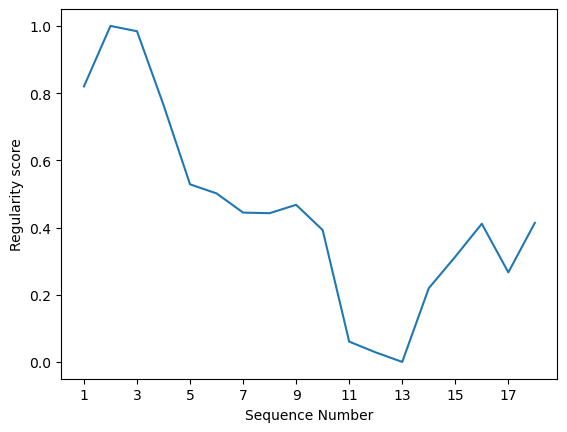

In [58]:
teacher1_regularity = plot_regularity(test_data, teacher1_predicted_sequences)
teacher1_mse = get_mse(test_data, teacher1_predicted_sequences)

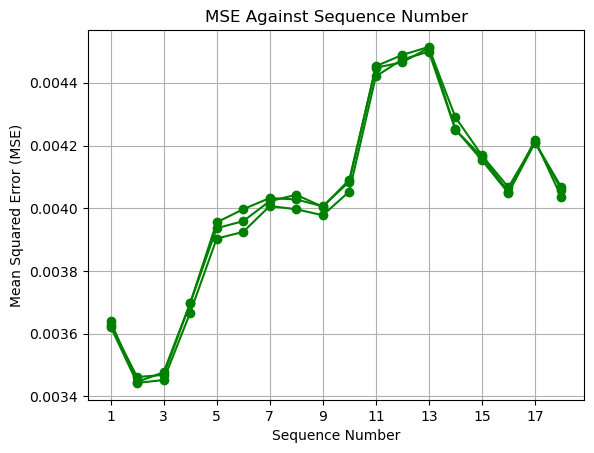

In [59]:
plot_mse_change(teacher1_mse)

### Teacher 2

In [60]:
teacher2_predicted_sequences = teacher2.predict(test_data)

1/1 [==============================] - 2s 2s/step


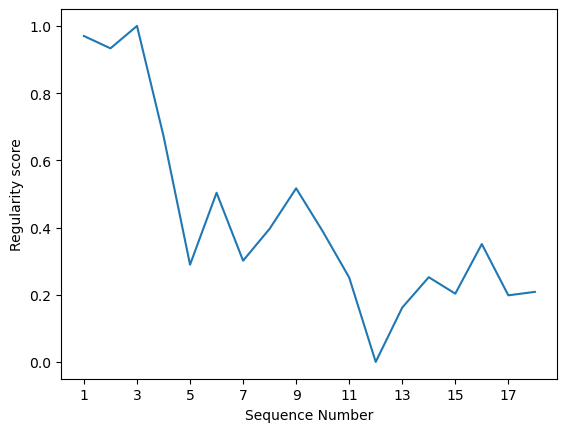

In [61]:
teacher2_regularity = plot_regularity(test_data, teacher2_predicted_sequences)
teacher2_mse = get_mse(test_data, teacher2_predicted_sequences)

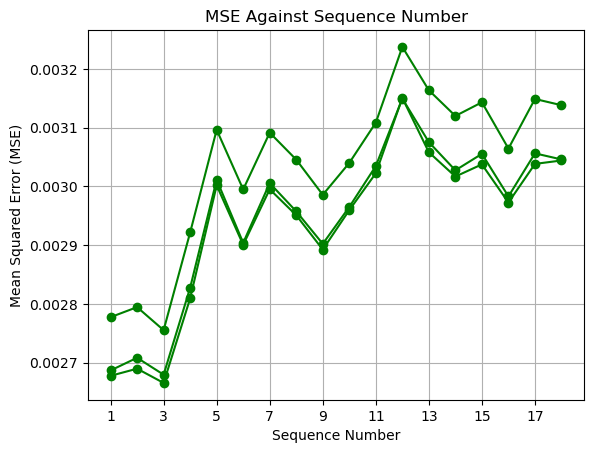

In [62]:
plot_mse_change(teacher2_mse)

## Student scores

### Student without kd scores

In [63]:
student1_predicted_sequences = student_model1.predict(test_data)

1/1 [==============================] - 3s 3s/step


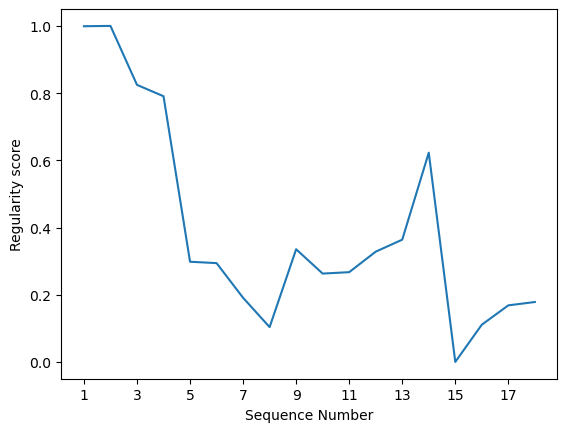

In [64]:
student1_regularity = plot_regularity(test_data, student1_predicted_sequences)
student1_mse = get_mse(test_data, student1_predicted_sequences)

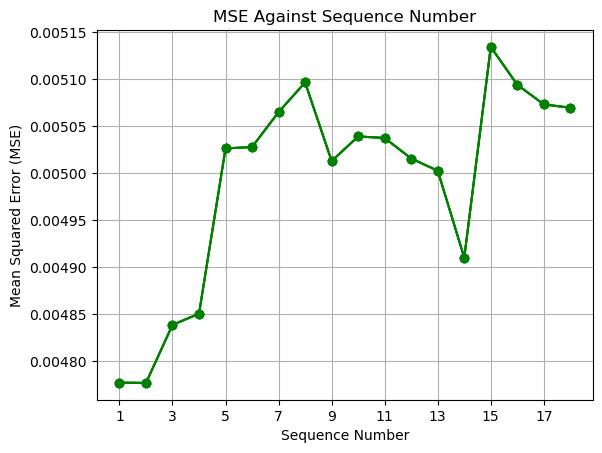

In [65]:
plot_mse_change(student1_mse)

### Student with kd scores

#### Single teacher 1

In [66]:
student_kd1_predicted_sequences = student_model_kd1.predict(test_data)

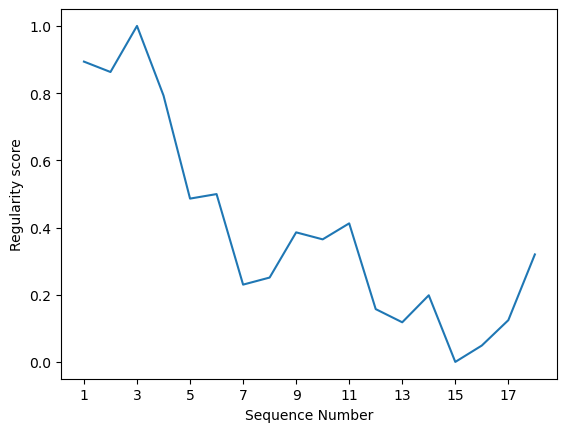

In [67]:
student_kd1_regularity = plot_regularity(test_data, student_kd1_predicted_sequences)
student_kd1_mse = get_mse(test_data, student_kd1_predicted_sequences)

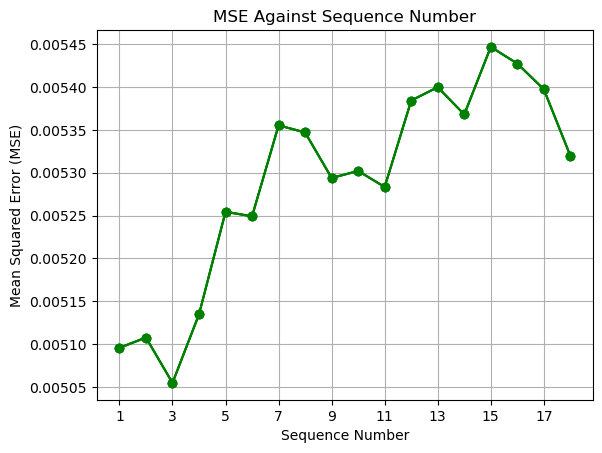

In [68]:
plot_mse_change(student_kd1_mse)

#### Single teacher 2

In [69]:
student_kd8_predicted_sequences = student_model_kd8.predict(test_data)

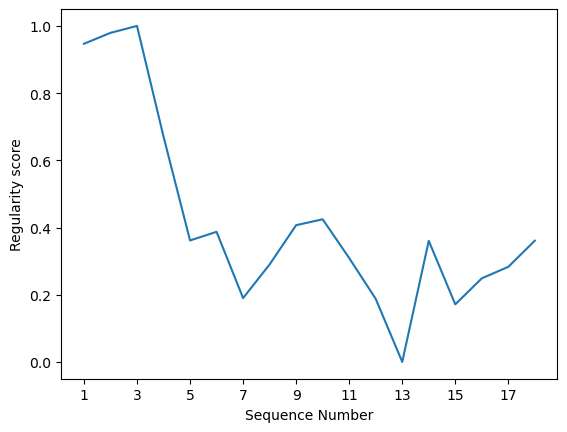

In [70]:
student_kd8_regularity = plot_regularity(test_data, student_kd8_predicted_sequences)
student_kd8_mse = get_mse(test_data, student_kd8_predicted_sequences)

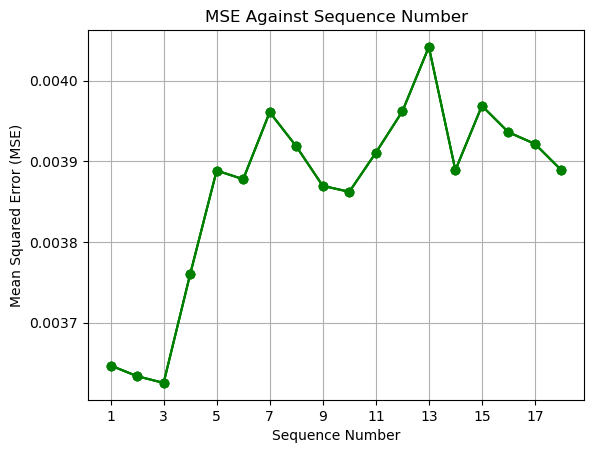

In [71]:
plot_mse_change(student_kd8_mse)

#### Two teachers

##### Two teachers 1

In [72]:
student_kd2_predicted_sequences = student_model_kd2.predict(test_data)

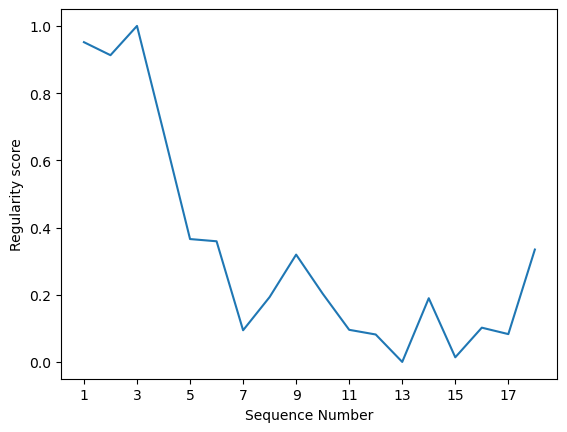

In [73]:
student_kd2_regularity = plot_regularity(test_data, student_kd2_predicted_sequences)
student_kd2_mse = get_mse(test_data, student_kd2_predicted_sequences)

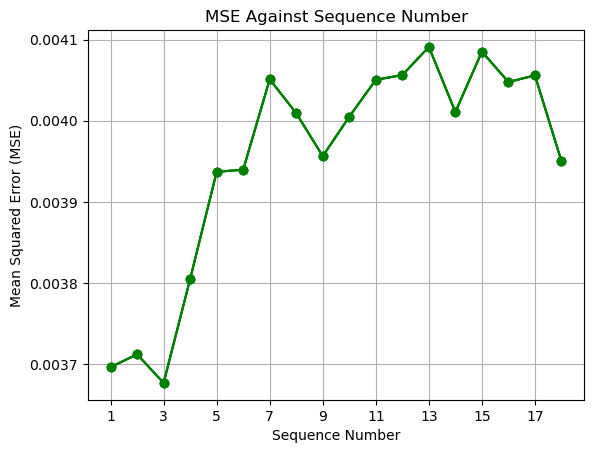

In [74]:
plot_mse_change(student_kd2_mse)

##### Two teachers 2

In [75]:
student_kd3_predicted_sequences = student_model_kd3.predict(test_data)

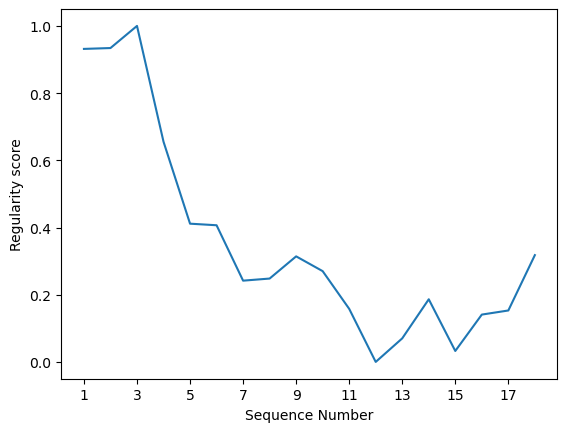

In [76]:
student_kd3_regularity = plot_regularity(test_data, student_kd3_predicted_sequences)
student_kd3_mse = get_mse(test_data, student_kd3_predicted_sequences)

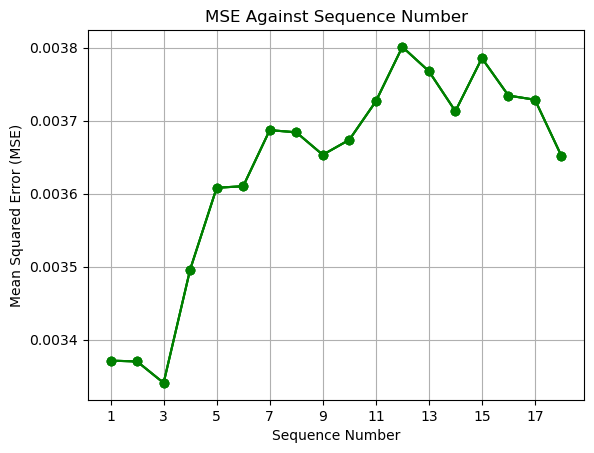

In [77]:
plot_mse_change(student_kd3_mse)

##### Two teachers 3

In [78]:
student_kd4_predicted_sequences = student_model_kd4.predict(test_data)

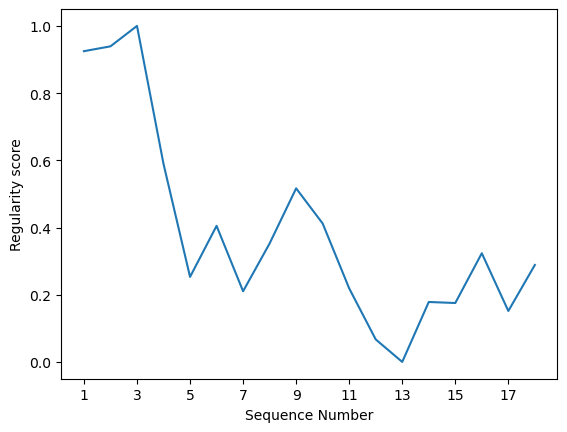

In [79]:
student_kd4_regularity = plot_regularity(test_data, student_kd4_predicted_sequences)
student_kd4_mse = get_mse(test_data, student_kd4_predicted_sequences)

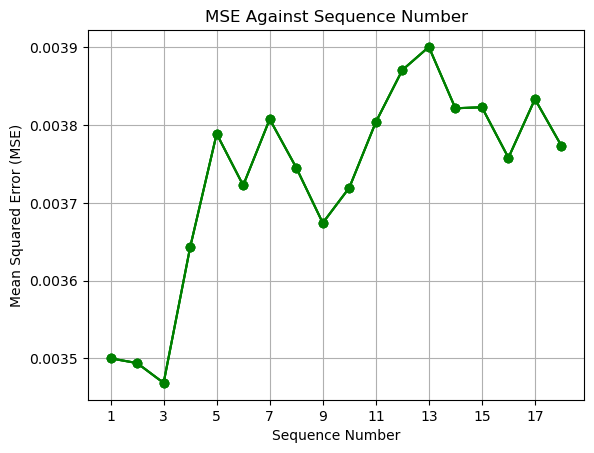

In [80]:
plot_mse_change(student_kd4_mse)

##### Two teachers 4

In [81]:
student_kd5_predicted_sequences = student_model_kd5.predict(test_data)

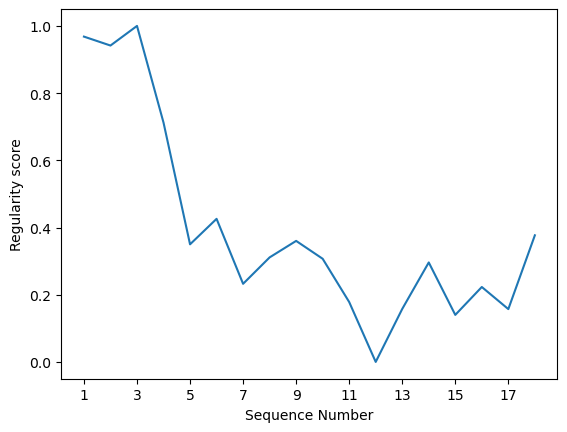

In [82]:
student_kd5_regularity = plot_regularity(test_data, student_kd5_predicted_sequences)
student_kd5_mse = get_mse(test_data, student_kd5_predicted_sequences)

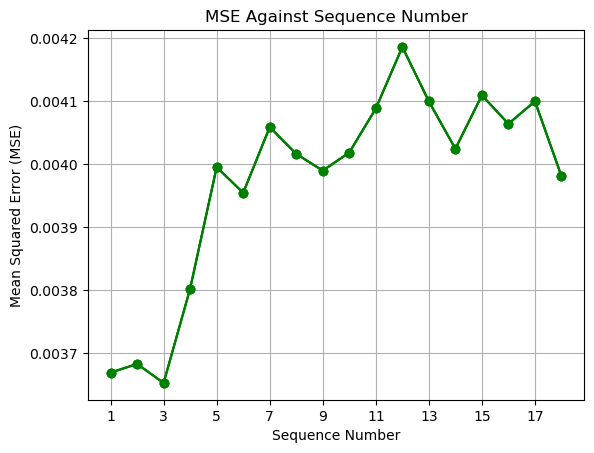

In [83]:
plot_mse_change(student_kd5_mse)

##### Two teachers 5 avg

In [84]:
student_kd6_predicted_sequences = student_model_kd6.predict(test_data)

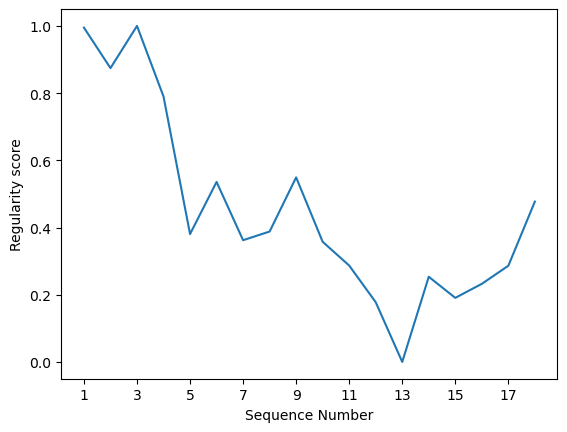

In [85]:
student_kd6_regularity = plot_regularity(test_data, student_kd6_predicted_sequences)
student_kd6_mse = get_mse(test_data, student_kd6_predicted_sequences)

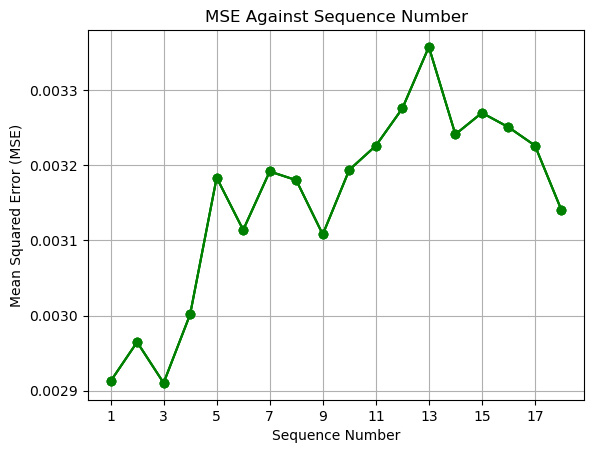

In [86]:
plot_mse_change(student_kd6_mse)

##### Two teachers 6 Dynamic weights

In [87]:
student_kd7_predicted_sequences = student_model_kd7.predict(test_data)

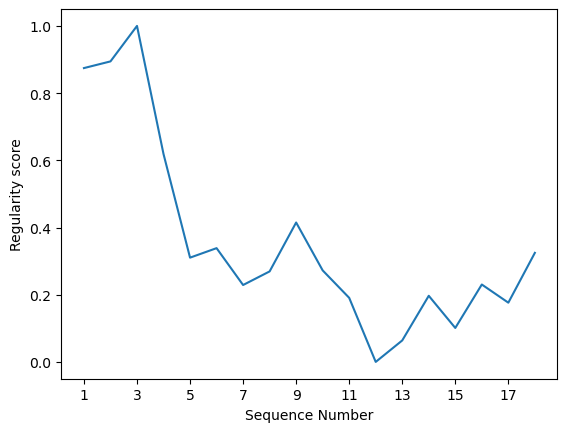

In [88]:
student_kd7_regularity = plot_regularity(test_data, student_kd7_predicted_sequences)
student_kd7_mse = get_mse(test_data, student_kd7_predicted_sequences)

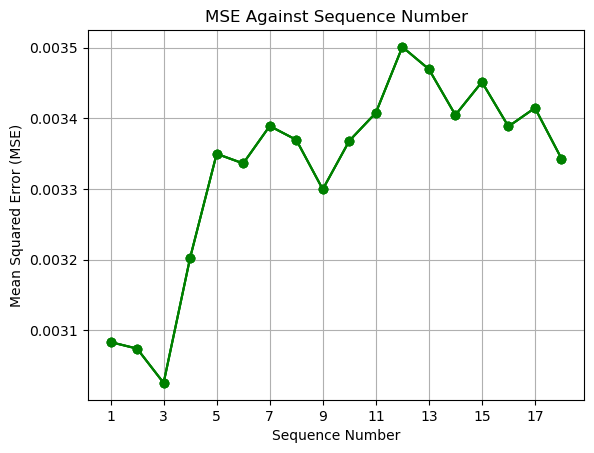

In [89]:
plot_mse_change(student_kd7_mse)

## Performance evaluation

In [90]:
print(teacher1_mse)

[[0.00363929 0.00362282 0.00362909]
 [0.00344626 0.00344311 0.00346185]
 [0.00347698 0.00345238 0.00346871]
 [0.00369696 0.00366682 0.00369653]
 [0.003955   0.00390325 0.00393651]
 [0.00399686 0.00392464 0.00395882]
 [0.00403247 0.00400707 0.00402248]
 [0.0040281  0.00399686 0.00404282]
 [0.00400592 0.00397765 0.00400458]
 [0.0040848  0.00405325 0.00409064]
 [0.00445276 0.00442045 0.00444794]
 [0.00448899 0.00447448 0.00446554]
 [0.00451433 0.00449919 0.00451131]
 [0.00425071 0.0042515  0.00429029]
 [0.0041637  0.00415323 0.00416834]
 [0.00405294 0.00404847 0.00406684]
 [0.00421755 0.00420926 0.00421048]
 [0.00403431 0.00405905 0.00406632]]


In [91]:
print(teacher2_mse)

[[0.00267755 0.00268669 0.00277736]
 [0.00268969 0.00270824 0.00279444]
 [0.00266545 0.00267946 0.00275523]
 [0.00280935 0.0028274  0.00292145]
 [0.0030017  0.00301117 0.00309624]
 [0.00290048 0.00290381 0.00299471]
 [0.00299501 0.00300546 0.00309132]
 [0.00295082 0.0029574  0.00304544]
 [0.00289242 0.00290212 0.00298558]
 [0.00295951 0.00296488 0.00303984]
 [0.00302227 0.00303455 0.00310838]
 [0.00315041 0.00314937 0.00323726]
 [0.00305799 0.00307522 0.0031635 ]
 [0.00301667 0.00302726 0.00311977]
 [0.00303737 0.00305528 0.003143  ]
 [0.00297249 0.00298286 0.00306429]
 [0.00303818 0.00305615 0.00314869]
 [0.00304399 0.00304576 0.00313806]]


In [92]:
print(student1_mse)

[[0.00477724 0.00477724 0.00477724]
 [0.00477698 0.00477698 0.00477698]
 [0.00483877 0.00483877 0.00483877]
 [0.00485068 0.00485068 0.00485068]
 [0.0050266  0.0050266  0.0050266 ]
 [0.00502809 0.00502809 0.00502809]
 [0.00506529 0.00506529 0.00506529]
 [0.00509685 0.00509685 0.00509685]
 [0.00501323 0.00501323 0.00501323]
 [0.00503933 0.00503933 0.00503933]
 [0.00503771 0.00503771 0.00503771]
 [0.00501583 0.00501583 0.00501583]
 [0.00500288 0.00500288 0.00500288]
 [0.00491034 0.00491034 0.00491034]
 [0.00513464 0.00513464 0.00513464]
 [0.00509432 0.00509432 0.00509432]
 [0.00507346 0.00507346 0.00507346]
 [0.00506989 0.00506989 0.00506989]]


In [93]:
print(student_kd1_mse)

[[0.00509578 0.00509578 0.00509578]
 [0.00510775 0.00510775 0.00510775]
 [0.00505484 0.00505484 0.00505484]
 [0.00513489 0.00513489 0.00513489]
 [0.00525444 0.00525444 0.00525444]
 [0.00524918 0.00524918 0.00524918]
 [0.0053553  0.0053553  0.0053553 ]
 [0.00534695 0.00534695 0.00534695]
 [0.00529387 0.00529387 0.00529387]
 [0.0053021  0.0053021  0.0053021 ]
 [0.0052834  0.0052834  0.0052834 ]
 [0.0053842  0.0053842  0.0053842 ]
 [0.00539977 0.00539977 0.00539977]
 [0.00536794 0.00536794 0.00536794]
 [0.00544675 0.00544675 0.00544675]
 [0.00542732 0.00542732 0.00542732]
 [0.00539731 0.00539731 0.00539731]
 [0.00531973 0.00531973 0.00531973]]


In [94]:
print(student_kd8_mse)

[[0.00364699 0.00364699 0.00364699]
 [0.00363378 0.00363378 0.00363378]
 [0.0036254  0.0036254  0.0036254 ]
 [0.00376005 0.00376005 0.00376005]
 [0.00388865 0.00388865 0.00388865]
 [0.00387788 0.00387788 0.00387788]
 [0.00396098 0.00396098 0.00396098]
 [0.00391867 0.00391867 0.00391867]
 [0.00386964 0.00386964 0.00386964]
 [0.00386229 0.00386229 0.00386229]
 [0.00391068 0.00391068 0.00391068]
 [0.00396192 0.00396192 0.00396192]
 [0.00404186 0.00404186 0.00404186]
 [0.00388913 0.00388913 0.00388913]
 [0.00396885 0.00396885 0.00396885]
 [0.00393612 0.00393612 0.00393612]
 [0.00392165 0.00392165 0.00392165]
 [0.00388891 0.00388891 0.00388891]]


In [95]:
print(student_kd2_mse)

[[0.00369634 0.00369634 0.00369634]
 [0.00371208 0.00371208 0.00371208]
 [0.00367686 0.00367686 0.00367686]
 [0.00380496 0.00380496 0.00380496]
 [0.00393696 0.00393696 0.00393696]
 [0.0039397  0.0039397  0.0039397 ]
 [0.00405096 0.00405096 0.00405096]
 [0.00400922 0.00400922 0.00400922]
 [0.00395627 0.00395627 0.00395627]
 [0.00400496 0.00400496 0.00400496]
 [0.0040504  0.0040504  0.0040504 ]
 [0.00405623 0.00405623 0.00405623]
 [0.00409092 0.00409092 0.00409092]
 [0.00401074 0.00401074 0.00401074]
 [0.00408508 0.00408508 0.00408508]
 [0.00404771 0.00404771 0.00404771]
 [0.00405584 0.00405584 0.00405584]
 [0.00394996 0.00394996 0.00394996]]


In [96]:
print(student_kd3_mse)

[[0.00337148 0.00337148 0.00337148]
 [0.00337029 0.00337029 0.00337029]
 [0.00334093 0.00334093 0.00334093]
 [0.00349619 0.00349619 0.00349619]
 [0.00360818 0.00360818 0.00360818]
 [0.00361032 0.00361032 0.00361032]
 [0.0036871  0.0036871  0.0036871 ]
 [0.00368417 0.00368417 0.00368417]
 [0.00365333 0.00365333 0.00365333]
 [0.00367385 0.00367385 0.00367385]
 [0.00372644 0.00372644 0.00372644]
 [0.00380108 0.00380108 0.00380108]
 [0.00376788 0.00376788 0.00376788]
 [0.00371306 0.00371306 0.00371306]
 [0.00378567 0.00378567 0.00378567]
 [0.00373448 0.00373448 0.00373448]
 [0.00372874 0.00372874 0.00372874]
 [0.00365158 0.00365158 0.00365158]]


In [97]:
print(student_kd4_mse)

[[0.00350017 0.00350017 0.00350017]
 [0.0034941  0.0034941  0.0034941 ]
 [0.00346859 0.00346859 0.00346859]
 [0.00364296 0.00364296 0.00364296]
 [0.00378884 0.00378884 0.00378884]
 [0.00372257 0.00372257 0.00372257]
 [0.00380761 0.00380761 0.00380761]
 [0.00374536 0.00374536 0.00374536]
 [0.00367421 0.00367421 0.00367421]
 [0.00371954 0.00371954 0.00371954]
 [0.00380383 0.00380383 0.00380383]
 [0.00387083 0.00387083 0.00387083]
 [0.00390053 0.00390053 0.00390053]
 [0.00382166 0.00382166 0.00382166]
 [0.00382297 0.00382297 0.00382297]
 [0.00375804 0.00375804 0.00375804]
 [0.00383345 0.00383345 0.00383345]
 [0.00377328 0.00377328 0.00377328]]


In [98]:
print(student_kd5_mse)

[[0.00366933 0.00366933 0.00366933]
 [0.00368306 0.00368306 0.00368306]
 [0.00365294 0.00365294 0.00365294]
 [0.00380269 0.00380269 0.00380269]
 [0.00399551 0.00399551 0.00399551]
 [0.00395475 0.00395475 0.00395475]
 [0.00405904 0.00405904 0.00405904]
 [0.00401653 0.00401653 0.00401653]
 [0.00399004 0.00399004 0.00399004]
 [0.00401872 0.00401872 0.00401872]
 [0.00408866 0.00408866 0.00408866]
 [0.00418639 0.00418639 0.00418639]
 [0.00409987 0.00409987 0.00409987]
 [0.00402468 0.00402468 0.00402468]
 [0.00410953 0.00410953 0.00410953]
 [0.00406431 0.00406431 0.00406431]
 [0.00410011 0.00410011 0.00410011]
 [0.00398111 0.00398111 0.00398111]]


In [99]:
print(student_kd6_mse)

[[0.00291232 0.00291232 0.00291232]
 [0.00296459 0.00296459 0.00296459]
 [0.00291014 0.00291014 0.00291014]
 [0.00300158 0.00300158 0.00300158]
 [0.00318381 0.00318381 0.00318381]
 [0.00311408 0.00311408 0.00311408]
 [0.00319204 0.00319204 0.00319204]
 [0.00318043 0.00318043 0.00318043]
 [0.00310807 0.00310807 0.00310807]
 [0.00319421 0.00319421 0.00319421]
 [0.00322626 0.00322626 0.00322626]
 [0.00327604 0.00327604 0.00327604]
 [0.00335803 0.00335803 0.00335803]
 [0.0032415  0.0032415  0.0032415 ]
 [0.00327016 0.00327016 0.00327016]
 [0.00325109 0.00325109 0.00325109]
 [0.00322656 0.00322656 0.00322656]
 [0.00314032 0.00314032 0.00314032]]


In [100]:
print(student_kd7_mse)

[[0.00308349 0.00308349 0.00308349]
 [0.00307426 0.00307426 0.00307426]
 [0.00302576 0.00302576 0.00302576]
 [0.0032028  0.0032028  0.0032028 ]
 [0.00334973 0.00334973 0.00334973]
 [0.0033361  0.0033361  0.0033361 ]
 [0.00338901 0.00338901 0.00338901]
 [0.00336951 0.00336951 0.00336951]
 [0.00329953 0.00329953 0.00329953]
 [0.00336803 0.00336803 0.00336803]
 [0.00340758 0.00340758 0.00340758]
 [0.00350084 0.00350084 0.00350084]
 [0.00346942 0.00346942 0.00346942]
 [0.00340462 0.00340462 0.00340462]
 [0.00345125 0.00345125 0.00345125]
 [0.00338834 0.00338834 0.00338834]
 [0.00341456 0.00341456 0.00341456]
 [0.00334285 0.00334285 0.00334285]]


In [101]:
all_models_mse = {
    "teacher1": teacher1_mse,
    "teacher2": teacher2_mse,
    "student1": student1_mse,
    "studentkd1": student_kd1_mse,
    "studentkd2": student_kd2_mse,
    "studentkd3": student_kd3_mse,
    "studentkd4": student_kd4_mse,
    "studentkd5": student_kd5_mse,
    "studentkd6": student_kd6_mse,
    "studentkd7": student_kd7_mse
}

In [102]:
print(teacher1_regularity)

[0.819996   1.         0.98420054 0.7645552  0.5284896  0.5015141
 0.44443202 0.44264442 0.46757275 0.39246017 0.06039238 0.02836877
 0.         0.21930999 0.31318206 0.41129225 0.26657748 0.4139163 ]


In [103]:
print(teacher2_regularity)

[0.96993893 0.9332832  1.         0.67226845 0.28945976 0.50342596
 0.30134565 0.39626873 0.51666445 0.3889627  0.2511536  0.
 0.1617617  0.25216407 0.20316958 0.3507918  0.19818479 0.20846939]


In [104]:
print(student1_regularity)

[0.9991046  1.         0.82455707 0.7907044  0.2981469  0.29409635
 0.19088054 0.1035971  0.33534116 0.26291698 0.2671432  0.3281439
 0.36386228 0.62272435 0.         0.11082858 0.16835922 0.17830467]


In [105]:
print(student_kd1_regularity)

[0.89378846 0.8628616  1.         0.7927928  0.48606628 0.49952126
 0.23004788 0.25109023 0.38562578 0.36476445 0.4123929  0.15718508
 0.11794263 0.19832641 0.         0.04876089 0.12427688 0.31990182]


In [106]:
print(student_kd8_regularity)

[0.94684    0.9793752  1.         0.67067075 0.3615442  0.38721365
 0.19000494 0.290111   0.40699255 0.42448938 0.30912817 0.18776
 0.         0.36041528 0.17138565 0.24875784 0.28305602 0.36093932]


In [107]:
print(student_kd2_regularity)

[0.9516308  0.9128856  1.         0.68479925 0.36567557 0.359051
 0.09421867 0.19306272 0.31935948 0.20324677 0.09556293 0.08163106
 0.         0.18960965 0.01374847 0.10194021 0.08278209 0.33445543]


In [108]:
print(student_kd3_regularity)

[0.9315932  0.9341691  1.         0.65532625 0.41143817 0.40674382
 0.24186575 0.24811357 0.31416053 0.2701829  0.15800321 0.
 0.07012558 0.18646294 0.0325892  0.14087391 0.15310264 0.3178522 ]


In [109]:
print(student_kd4_regularity)

[0.92483616 0.9392637  1.         0.58921385 0.25302458 0.40492493
 0.21029061 0.3525777  0.5166192  0.4119889  0.21882337 0.06699026
 0.         0.17837578 0.17533898 0.32347196 0.1516115  0.288638  ]


In [110]:
print(student_kd5_regularity)

[0.96818984 0.9416126  1.         0.7122481  0.3499925  0.4258415
 0.23248512 0.31108588 0.36019045 0.3069952  0.17823946 0.
 0.15769166 0.296057   0.13998759 0.22301215 0.15723091 0.37683523]


In [111]:
print(student_kd6_regularity)

[0.99489605 0.87442553 1.         0.78984976 0.3805442  0.5357187
 0.36232358 0.38805258 0.54921997 0.35754317 0.2868275  0.17773789
 0.         0.25339842 0.1906547  0.23236966 0.28616416 0.4771927 ]


In [112]:
print(student_kd7_regularity)

[0.8745277  0.8944081  1.         0.6187322  0.3103441  0.33861732
 0.22890425 0.26936597 0.41495013 0.2724098  0.19073194 0.
 0.06392992 0.19681704 0.10110456 0.23039085 0.17631161 0.32460886]


In [113]:
def compare_regularity(regularity_scores, legend, threshold=0.6, doPlotThreshold=False):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Define a list of colors
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'brown', 'pink', 'olive', 'teal', 'navy']

    # Plot each line with a unique color
    for i, scores in enumerate(regularity_scores):
        frame_numbers = [x+1 for x in range(len(scores))]
        plt.plot(frame_numbers, scores, color=colors[i % len(colors)])

    # Add labels and title
    plt.xlabel('Sequence number')
    plt.ylabel('Regularity')
    plt.title('Regularity comparison')
    
    sequence_numbers = [i for i in range(1, len(regularity_scores[0]) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    
    # Add threshold line if required
    if doPlotThreshold:
        plt.axhline(y=threshold, color='black', linestyle='--')

    # Add legend
    plt.legend(legend, loc='lower left', bbox_to_anchor=(1.02, 0))
#     plt.legend(legend, loc='lower left')

    # Show plot
    plt.show()

In [114]:
# compare_regularity([teacher1_regularity, teacher2_regularity, student1_regularity, student_kd1_regularity, student_kd2_regularity, student_kd3_regularity, student_kd4_regularity, student_kd5_regularity, student_kd6_regularity, student_kd7_regularity], ["Teacher 1", "Teacher 2", "Student", "StudentKD1", "StudentKD2", "StudentKD3", "StudentKD4", "StudentKD5", "StudentKD6 AVG", "StudentKD7 DYNAMIC"])
# compare_mse([teacher1_mse-mean, teacher2_mse-mean, student_kd7_mse-mean], ["Teacher 1", "Teacher 2", "StudentKD7 DYNAMIC"], min=0, max=0, doPlotThreshold=False)

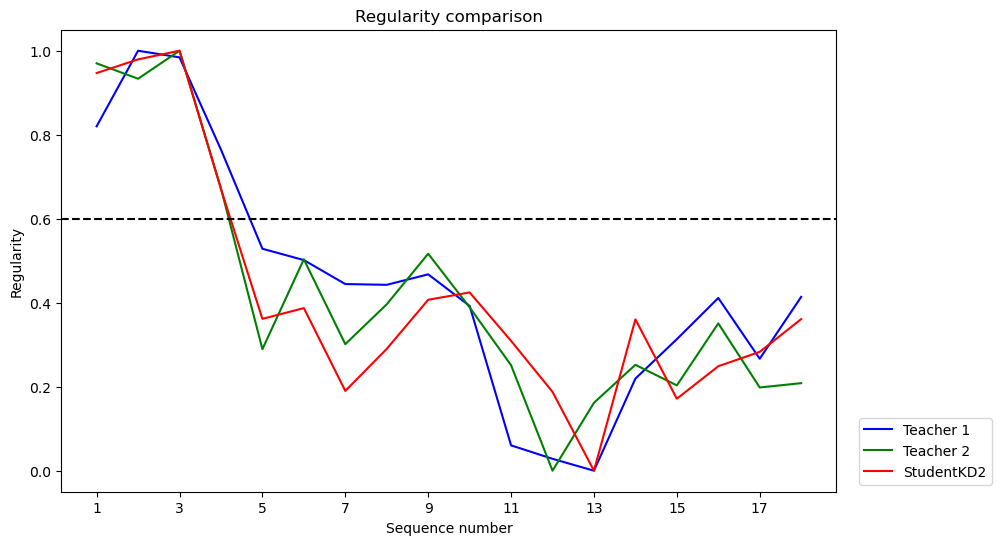

In [115]:
compare_regularity([teacher1_regularity, teacher2_regularity, student_kd8_regularity], ["Teacher 1", "Teacher 2", "StudentKD2"], doPlotThreshold=True)

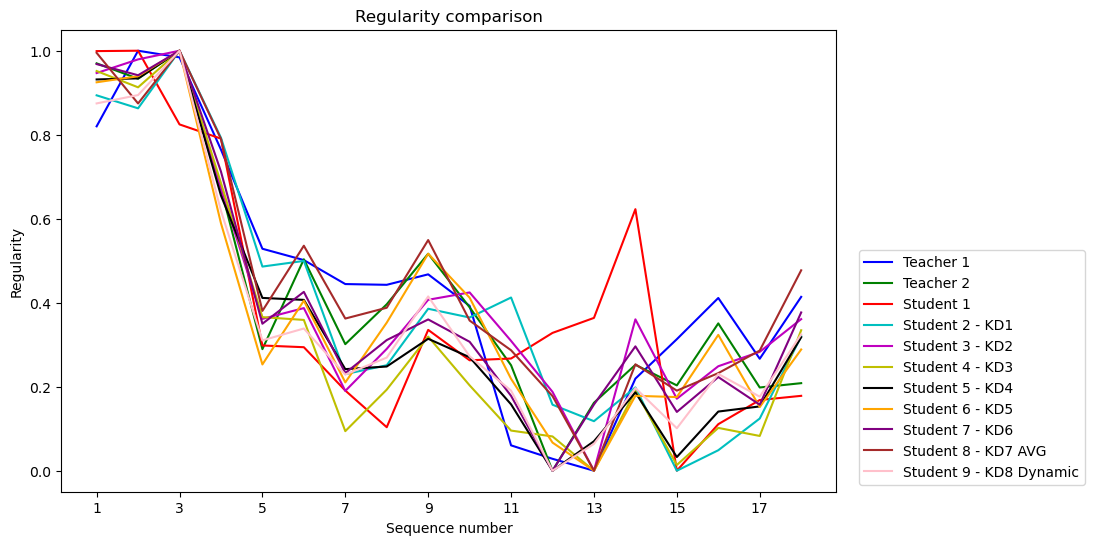

In [127]:
regularity_temp = [teacher1_regularity, teacher2_regularity, student1_regularity, student_kd1_regularity, student_kd8_regularity, student_kd2_regularity, student_kd3_regularity, student_kd4_regularity, student_kd5_regularity, student_kd6_regularity, student_kd7_regularity]
names_temp = ["Teacher 1", "Teacher 2", "Student 1", "Student 2 - KD1", "Student 3 - KD2", "Student 4 - KD3", "Student 5 - KD4", "Student 6 - KD5", "Student 7 - KD6", "Student 8 - KD7 AVG", "Student 9 - KD8 Dynamic"]
compare_regularity(regularity_temp, names_temp, doPlotThreshold=False)

In [117]:
def compare_mse(mse_scores, legend, min, max, doPlotThreshold=False):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Plot each line
    for scores in mse_scores:
        frame_numbers = [x+1 for x in range(len(scores))]
        plt.plot(frame_numbers, scores)

    # Add labels and title
    plt.xlabel('Sequence')
    plt.ylabel('MSE')
    plt.title('MSE comparision')

    if doPlotThreshold:
        plt.axhline(y=min, color='black', linestyle='--')
        plt.axhline(y=max, color='black', linestyle='--')

    plt.legend(legend)

    # Show plot
    plt.show()

In [118]:
# plot_mse_change(teacher1_mse, mean_mse=mean_mse_values["teacher1"], legend=["Teacher 1"], doPlotThreshold=True)
# plot_mse_change(teacher2_mse, mean_mse=mean_mse_values["teacher2"], legend=["Teacher 2"], doPlotThreshold=True)
# plot_mse_change(student1_mse, mean_mse=mean_mse_values["student1"], legend=["Student 1"], doPlotThreshold=True)
# plot_mse_change(student_kd1_mse, mean_mse=mean_mse_values["studentkd1"], legend=["Student KD1"], doPlotThreshold=True)
# plot_mse_change(student_kd2_mse, mean_mse=mean_mse_values["studentkd2"], legend=["Student KD2"], doPlotThreshold=True)
# plot_mse_change(student_kd3_mse, mean_mse=mean_mse_values["studentkd3"], legend=["Student KD3"], doPlotThreshold=True)
# plot_mse_change(student_kd4_mse, mean_mse=mean_mse_values["studentkd4"], legend=["Student KD4"], doPlotThreshold=True)
# plot_mse_change(student_kd5_mse, mean_mse=mean_mse_values["studentkd5"], legend=["Student KD5"], doPlotThreshold=True)
# plot_mse_change(student_kd6_mse, mean_mse=mean_mse_values["studentkd6"], legend=["Student KD6"], doPlotThreshold=True)
# plot_mse_change(student_kd7_mse, mean_mse=mean_mse_values["studentkd7"], legend=["Student KD7"], doPlotThreshold=True)
# plot_mse_change(student_kd7_mse, mean_mse=mean_mse_values["studentkd8"], legend=["Student KD8"], doPlotThreshold=True)


In [119]:
from sklearn.metrics import roc_auc_score, roc_curve

def calculate_metrics(pred_val, threshold, groundtruth):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    metrics = {}
    
#     pred_val = pred_val[:,0]
    for i in range(len(groundtruth)):
        pred = pred_val[i]
        truth = groundtruth[i]
        
        if pred < threshold:  # Anomaly detected
            if truth == 1:  # True positive
                tp += 1
            else:  # False positive
                fp += 1
        else:  # No anomaly detected
            if truth == 0:  # True negative
                tn += 1
            else:  # False negative
                fn += 1
    
    metrics["confusion_matrix"] = tp, fp, tn, fn
    
    metrics["tpr"] = tp / (tp + fn)
    metrics["fpr"] = fp / (fp + tn)
    
    metrics['precision'] = tp / (tp + fp)
    metrics['specificity'] = tn / (tn + fp)
    
    
    #EER
    far = fp / (fp + tn)
    frr = fn / (fn + tp)
    metrics['eer'] = ((far + frr) / 2) * 100
    
    metrics["accuracy"] = ((tp + tn) / (tp + tn + fp + fn)) * 100
    
    # Calculate ROC curve and AUC
    inverse_pred = 1 - pred_val
    fpr, tpr, thresholds = roc_curve(groundtruth, inverse_pred)
    #metrics["roc_curve"] = (fpr, tpr)
    metrics["auc"] = roc_auc_score(groundtruth, inverse_pred)
    
    return metrics

In [120]:
ground_truth_test_007 = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ground_truth_test_002 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ground_truth_test_004 = [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
ground_truth_test_003 = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

all_ground_truths = []
all_ground_truths.extend(ground_truth_test_007)
all_ground_truths.extend(ground_truth_test_002)
all_ground_truths.extend(ground_truth_test_004)
all_ground_truths.extend(ground_truth_test_003)

print(len(all_ground_truths))

69


In [121]:
def get_predicted_mse(model, test_data):
    model_predicted_sequences = model.predict(test_data)
    model_mse = get_mse(test_data, model_predicted_sequences)
    return model_mse

In [122]:
def get_predicted_regularity(model, sequences):
    reconstructed_sequences = model.predict(sequences)
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,len(sequences))])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost) - np.min(sequences_reconstruction_cost))
    sr = 1.0 - sa
    # ( mse - min_mse ) / max_mse - min_mse
    return sr

In [123]:
test_data1 = preprocess_test_dataset(test_path1)
test_data2 = preprocess_test_dataset(test_path2)
test_data3 = preprocess_test_dataset(test_path3)
test_data4 = preprocess_test_dataset(test_path4)

In [124]:
import pickle

all_metrics = {}

threshold = 0.60
    
if not all_metrics:
    for modelname in all_models.keys():
        #both all_model_mse and mean_mse_values have the same keys
        print(modelname)
        model_reg1 = get_predicted_regularity(all_models[modelname], test_data1)
        model_reg2 = get_predicted_regularity(all_models[modelname], test_data2)
        model_reg3 = get_predicted_regularity(all_models[modelname], test_data3)
        model_reg4 = get_predicted_regularity(all_models[modelname], test_data4)
        
        concatenated_mse = np.concatenate((model_reg1, model_reg2, model_reg3, model_reg4))
        all_metrics[modelname] = calculate_metrics(concatenated_mse, threshold, all_ground_truths)
        print(all_metrics[modelname], "\n\n")
    

teacher1
1/1 [==============================] - 8s 8s/step
{'confusion_matrix': (50, 0, 16, 3), 'tpr': 0.9433962264150944, 'fpr': 0.0, 'precision': 1.0, 'specificity': 1.0, 'eer': 2.8301886792452833, 'accuracy': 95.65217391304348, 'auc': 0.9734669811320755} 


teacher2
1/1 [==============================] - 1s 1s/step
{'confusion_matrix': (44, 1, 15, 9), 'tpr': 0.8301886792452831, 'fpr': 0.0625, 'precision': 0.9777777777777777, 'specificity': 0.9375, 'eer': 11.61556603773585, 'accuracy': 85.5072463768116, 'auc': 0.9640330188679245} 


student1
1/1 [==============================] - 2s 2s/step
{'confusion_matrix': (35, 7, 9, 18), 'tpr': 0.660377358490566, 'fpr': 0.4375, 'precision': 0.8333333333333334, 'specificity': 0.5625, 'eer': 38.85613207547169, 'accuracy': 63.76811594202898, 'auc': 0.7116745283018867} 


studentkd1
{'confusion_matrix': (36, 2, 14, 17), 'tpr': 0.6792452830188679, 'fpr': 0.125, 'precision': 0.9473684210526315, 'specificity': 0.875, 'eer': 22.287735849056602, 'accura

In [125]:
import pandas as pd
df = pd.DataFrame.from_dict(all_metrics)
df = df.transpose()
df

,confusion_matrix,tpr,fpr,precision,specificity,eer,accuracy,auc
teacher1,"(50, 0, 16, 3)",0.943396,0.0,1.0,1.0,2.830189,95.652174,0.973467
teacher2,"(44, 1, 15, 9)",0.830189,0.0625,0.977778,0.9375,11.615566,85.507246,0.964033
student1,"(35, 7, 9, 18)",0.660377,0.4375,0.833333,0.5625,38.856132,63.768116,0.711675
studentkd1,"(36, 2, 14, 17)",0.679245,0.125,0.947368,0.875,22.287736,72.463768,0.822524
studentkd2,"(40, 0, 16, 13)",0.754717,0.0,1.0,1.0,12.264151,81.15942,0.908608
studentkd3,"(41, 0, 16, 12)",0.773585,0.0,1.0,1.0,11.320755,82.608696,0.927476
studentkd4,"(45, 1, 15, 8)",0.849057,0.0625,0.978261,0.9375,10.67217,86.956522,0.948703
studentkd5,"(44, 0, 16, 9)",0.830189,0.0,1.0,1.0,8.490566,86.956522,0.954599
studentkd6,"(42, 0, 16, 11)",0.792453,0.0,1.0,1.0,10.377358,84.057971,0.930425
studentkd7,"(42, 0, 16, 11)",0.792453,0.0,1.0,1.0,10.377358,84.057971,0.926297


In [126]:
df.to_csv(MODEL_METRICS_TABULATED_PATH)